In [12]:
import random

import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
from egg import core
from egg.zoo.simple_autoenc.features import OneHotLoader
from egg.zoo.simple_autoenc.archs import Sender
from egg.zoo.simple_autoenc.train import get_params

In [13]:
opts = core.init(params=['--random_seed=7', 
                         '--n_epochs=50',
                         '--batch_size=10'])
opts.n_features = 10
opts.batches_per_epoch = 1000
opts.sender_entropy_coeff = 0.01
opts.receiver_entropy_coeff = 0.01
opts.alphabet_size = 8
opts.sender_population_size = 3
opts.receiver_population_size = 3
opts.lr = 1e-2

In [16]:
def loss(sender_input, _message, _receiver_input, receiver_output, _labels):
    acc = (receiver_output == sender_input.argmax(dim=1)).detach().float().mean(dim=0)
    return -acc, {'acc': acc.item()}

train_loader = OneHotLoader(n_features=opts.n_features, batch_size=opts.batch_size,
                            batches_per_epoch=opts.batches_per_epoch)
test_loader = OneHotLoader(n_features=opts.n_features, batch_size=opts.batch_size,
                            batches_per_epoch=opts.batches_per_epoch, seed=7)

class Receiver(nn.Module):
    def __init__(self, n_hidden, n_features):
        super(Receiver, self).__init__()
        self.output = core.RelaxedEmbedding(n_hidden, n_features)

    def forward(self, x, _input):
        return self.output(x)

senders = [core.ReinforceWrapper(Sender(opts.alphabet_size, opts.n_features)) 
           for _ in range(opts.sender_population_size)]
receivers = [core.ReinforceWrapper(Receiver(opts.n_features, opts.alphabet_size)) 
             for _ in range(opts.receiver_population_size)]

In [22]:
class MultiAgentGame(nn.Module):

    def __init__(self, senders, receivers, loss, sender_entropy_coeff=opts.sender_entropy_coeff, receiver_entropy_coeff=opts.sender_entropy_coeff):
        super(MultiAgentGame, self).__init__()
        self.senders = senders
        self.receivers = receivers
        self.loss = loss

        self.receiver_entropy_coeff = receiver_entropy_coeff
        self.sender_entropy_coeff = sender_entropy_coeff

        self.mean_baseline = 0.0
        self.n_points = 0.0

    def forward(self, sender_input, labels, receiver_input=None):
        sender, receiver = np.random.choice(senders), np.random.choice(receivers)
        message, sender_log_prob, sender_entropy = sender(sender_input)
        receiver_output, receiver_log_prob, receiver_entropy = receiver(message, receiver_input)

        loss, rest_info = self.loss(sender_input, message, receiver_input, receiver_output, labels)
        policy_loss = ((loss.detach() - self.mean_baseline) * (sender_log_prob + receiver_log_prob)).mean()
        entropy_loss = -(sender_entropy.mean() * self.sender_entropy_coeff + receiver_entropy.mean() * self.receiver_entropy_coeff)

        if self.training:
            self.n_points += 1.0
            self.mean_baseline += (loss.detach().mean().item() -
                                   self.mean_baseline) / self.n_points

        full_loss = policy_loss + entropy_loss

        rest_info['baseline'] = self.mean_baseline
        rest_info['loss'] = loss.mean().item()
        rest_info['sender_entropy'] = sender_entropy.mean()
        rest_info['receiver_entropy'] = receiver_entropy.mean()
        return full_loss, rest_info

In [23]:
import neptune
from neptune.experiments import Experiment
import seaborn as sns
import matplotlib.pyplot as plt

def save_sender_codebook(experiment, senders, epoch):
    figure, axes = plt.subplots(1,len(receivers),sharey=True, figsize=(20,5))
    figure.suptitle(f'Epoch {epoch}')
    for i, (sender, ax) in enumerate(zip(senders, axes)):
        g = sns.heatmap(F.softmax(sender.agent.fc1.weight.detach(), dim=0).numpy(), annot=True, fmt='.2f', ax=ax)
        g.set_title(f'Sender {i}')
    figure.savefig('fig.jpg')
    experiment.log_image('senders', 'fig.jpg')
    

class NeptuneMonitor:
        
    def __init__(self, experiment: Experiment = None):
        self.experiment = experiment if experiment else neptune
    
    def log(self, mode, epoch, loss, rest):
        self.experiment.send_metric(f'{mode}_loss', loss)
        for metric, value in rest.items():
            self.experiment.send_metric(f'{mode}_{metric}', value)

In [26]:
class CustomTrainer(core.Trainer):

    def train(self, n_epochs):
        while self.epoch < n_epochs:
            train_loss, train_rest = self.train_epoch()

            self.epoch += 1

            self.monitor.log('train', self.epoch, train_loss, train_rest)
            
            if self.validation_data is not None and self.validation_freq > 0 and self.epoch % self.validation_freq == 0:
                validation_loss, rest = self.eval()
                self.monitor.log('validation', self.epoch, validation_loss, rest)
                print(f'validation: epoch {self.epoch}, loss {validation_loss},  {rest}', flush=True)
                save_sender_codebook(self.monitor.experiment, self.game.senders, self.epoch)

                if self.early_stopping:
                    self.early_stopping.update_values(validation_loss, rest, train_loss, rest, self.epoch)
                    if self.early_stopping.should_stop(): break

EGG-29
https://ui.neptune.ml/tomekkorbak/egg/e/EGG-29
validation: epoch 1, loss -0.021425947546958923,  {'acc': 0.12500000263750552, 'baseline': -0.11920000234991333, 'loss': -0.12500000263750552, 'sender_entropy': tensor(1.8979), 'receiver_entropy': tensor(1.8015)}
validation: epoch 2, loss 0.025241930037736893,  {'acc': 0.14480000292509795, 'baseline': -0.1252000025250028, 'loss': -0.14480000292509795, 'sender_entropy': tensor(1.8410), 'receiver_entropy': tensor(1.7774)}
validation: epoch 3, loss 0.02841840870678425,  {'acc': 0.1530000032559037, 'baseline': -0.13053333600113654, 'loss': -0.1530000032559037, 'sender_entropy': tensor(1.7789), 'receiver_entropy': tensor(1.7275)}
validation: epoch 4, loss 0.07800795137882233,  {'acc': 0.18270000395178795, 'baseline': -0.14140000298433028, 'loss': -0.18270000395178795, 'sender_entropy': tensor(1.6375), 'receiver_entropy': tensor(1.6435)}
validation: epoch 5, loss 0.10739545524120331,  {'acc': 0.20300000425428152, 'baseline': -0.1498800031

/Users/tomek/.virtualenvs/x/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


validation: epoch 22, loss 0.14626163244247437,  {'acc': 0.756899999320507, 'baseline': -0.43995454954490676, 'loss': -0.756899999320507, 'sender_entropy': tensor(0.4237), 'receiver_entropy': tensor(0.1766)}
validation: epoch 23, loss 0.1292475461959839,  {'acc': 0.7650999983847141, 'baseline': -0.45372609080243764, 'loss': -0.7650999983847141, 'sender_entropy': tensor(0.3902), 'receiver_entropy': tensor(0.1520)}
validation: epoch 24, loss 0.11224443465471268,  {'acc': 0.7733999982774258, 'baseline': -0.46677917028900273, 'loss': -0.7733999982774258, 'sender_entropy': tensor(0.3828), 'receiver_entropy': tensor(0.1225)}
validation: epoch 25, loss 0.09081804752349854,  {'acc': 0.7807999976724386, 'baseline': -0.4792680034130851, 'loss': -0.7807999976724386, 'sender_entropy': tensor(0.3315), 'receiver_entropy': tensor(0.0906)}
validation: epoch 26, loss 0.08455725759267807,  {'acc': 0.7839999973773957, 'baseline': -0.49088077240895694, 'loss': -0.7839999973773957, 'sender_entropy': tensor

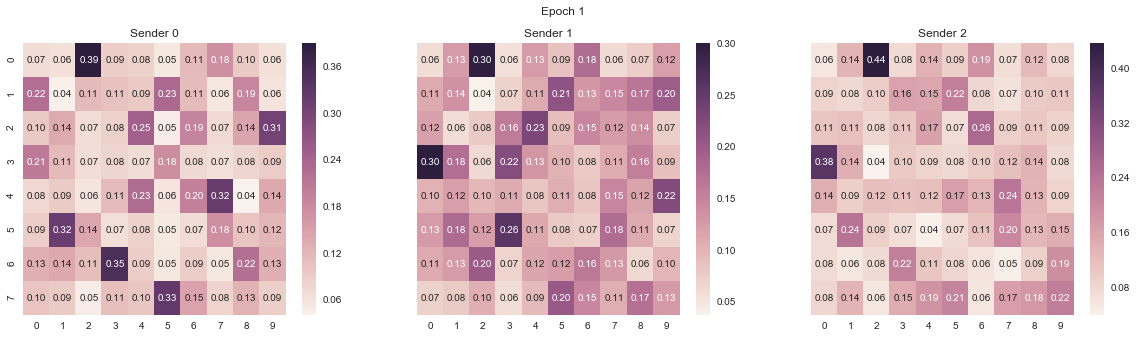

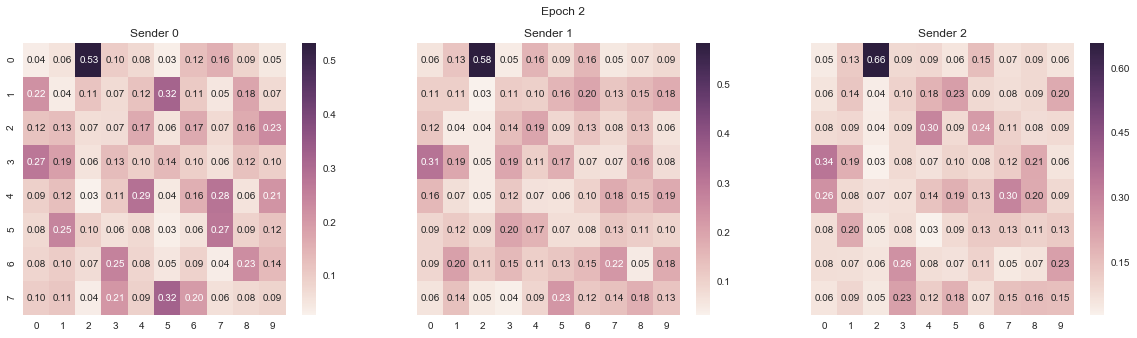

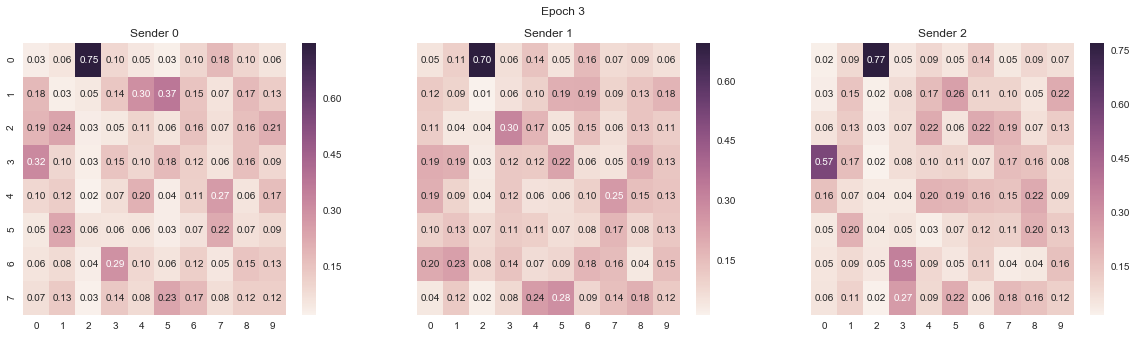

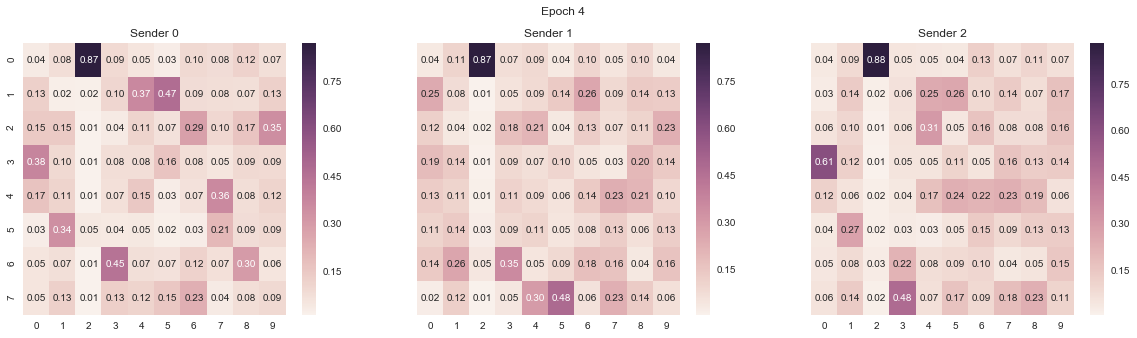

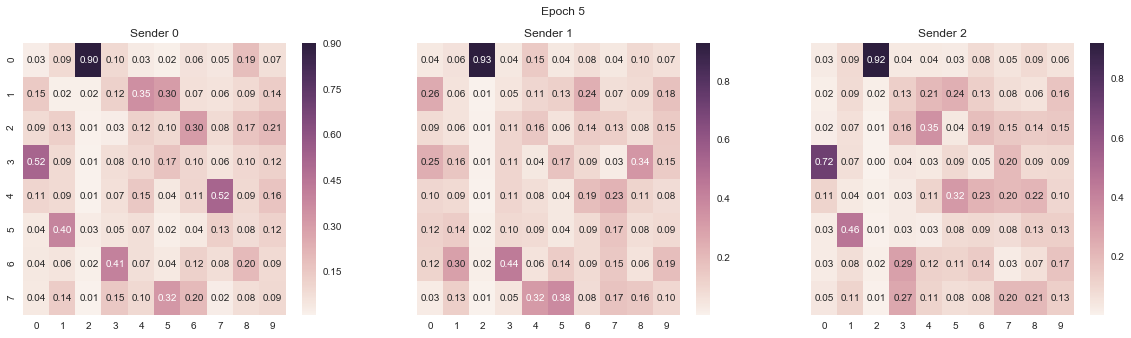

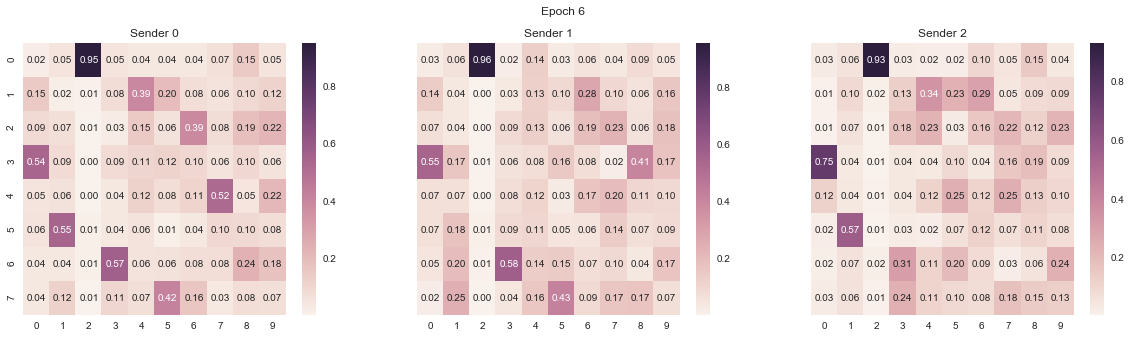

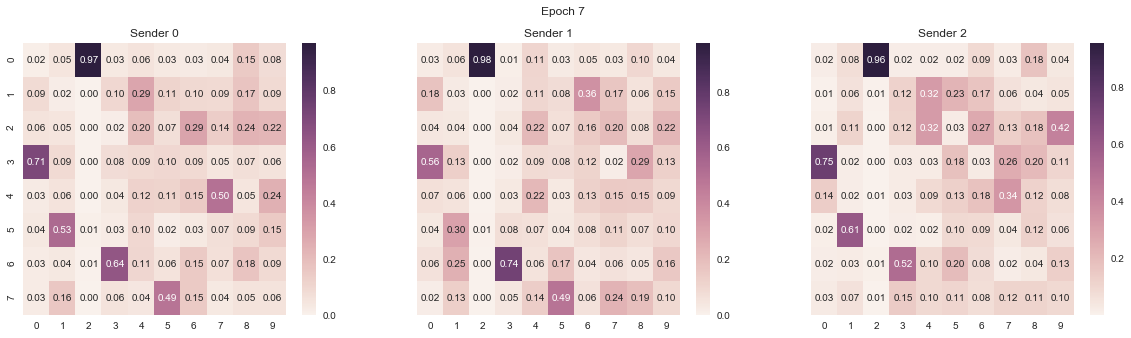

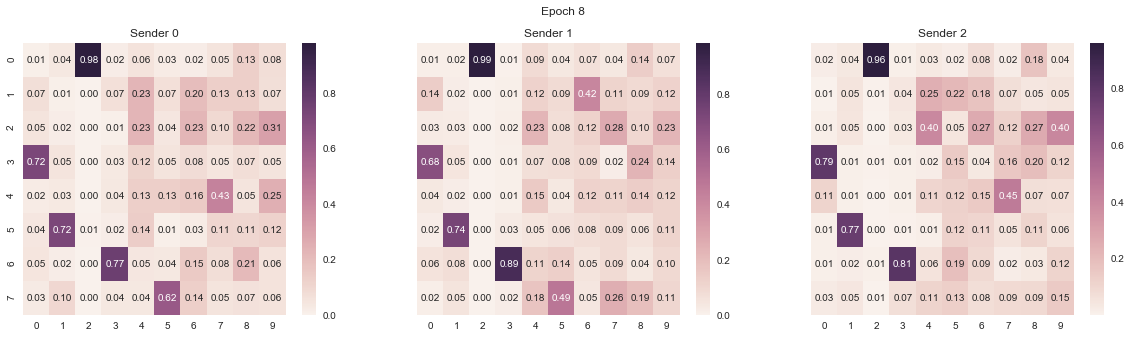

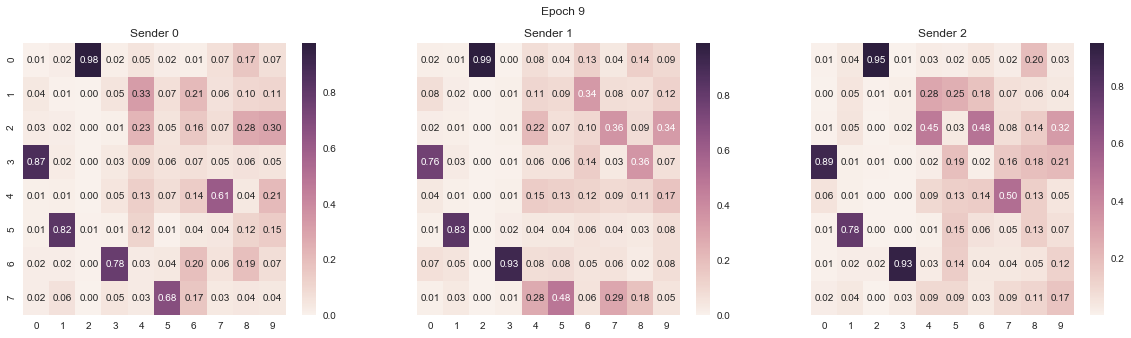

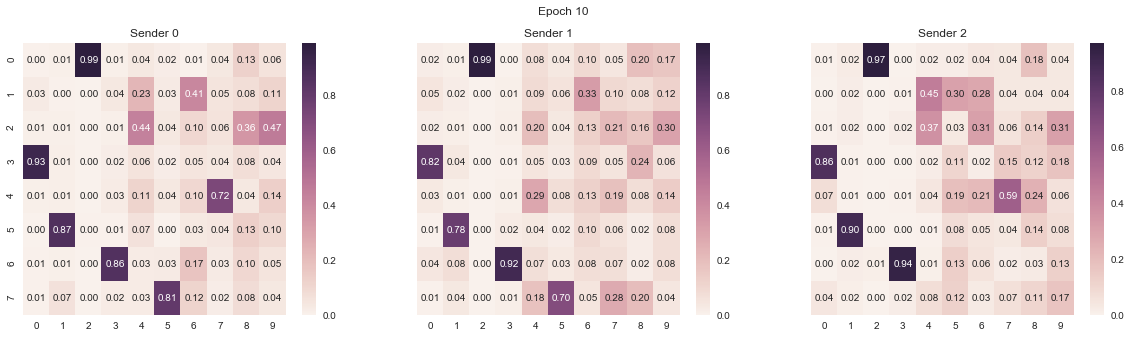

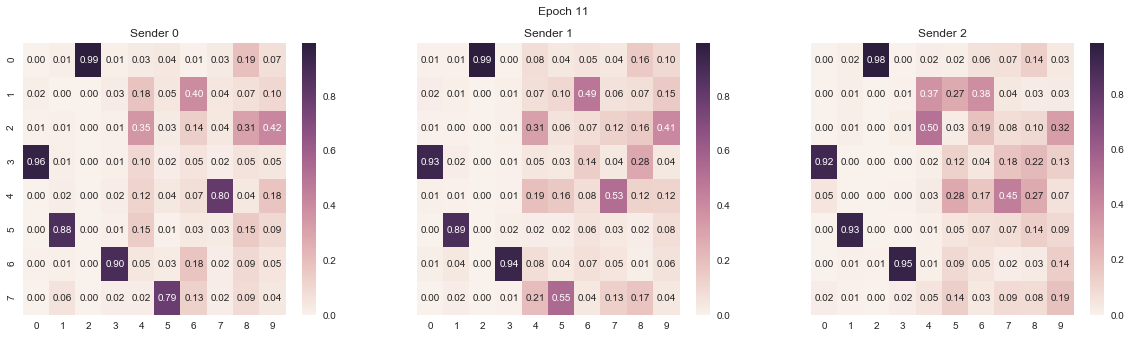

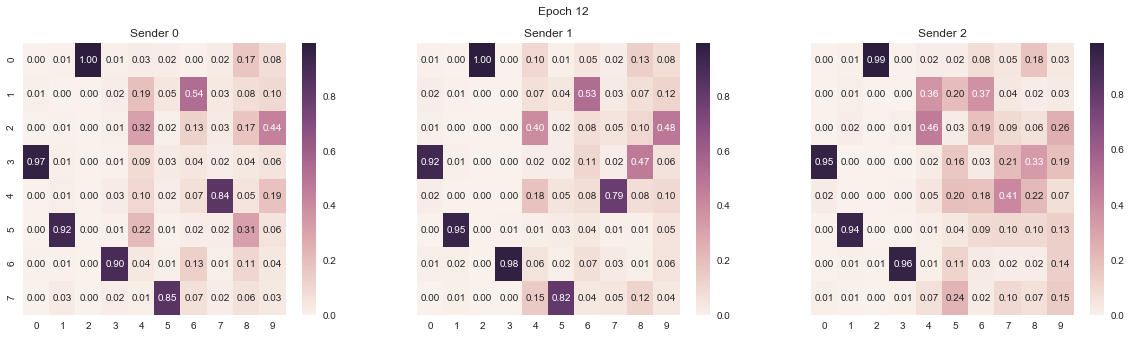

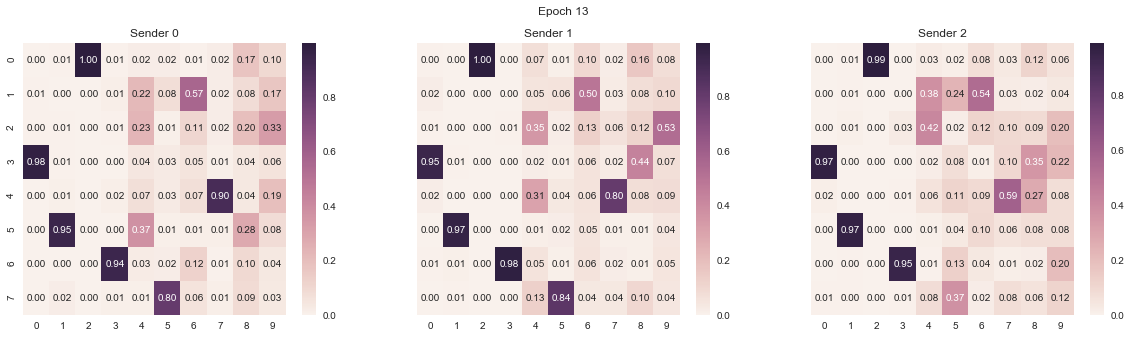

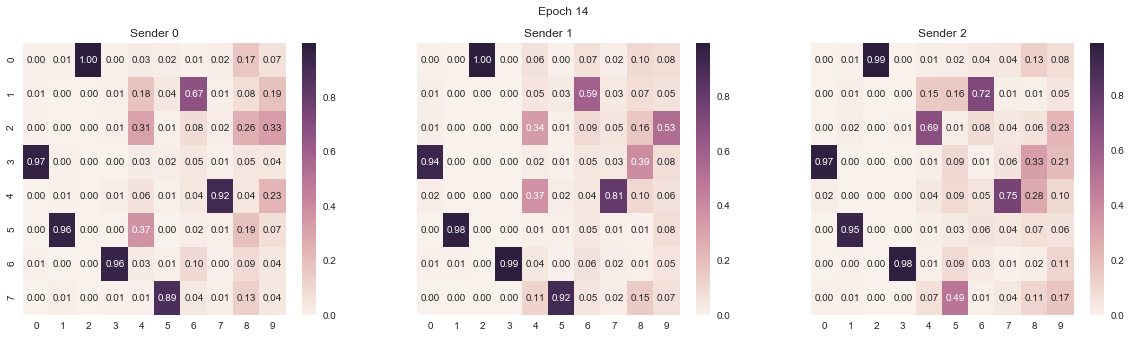

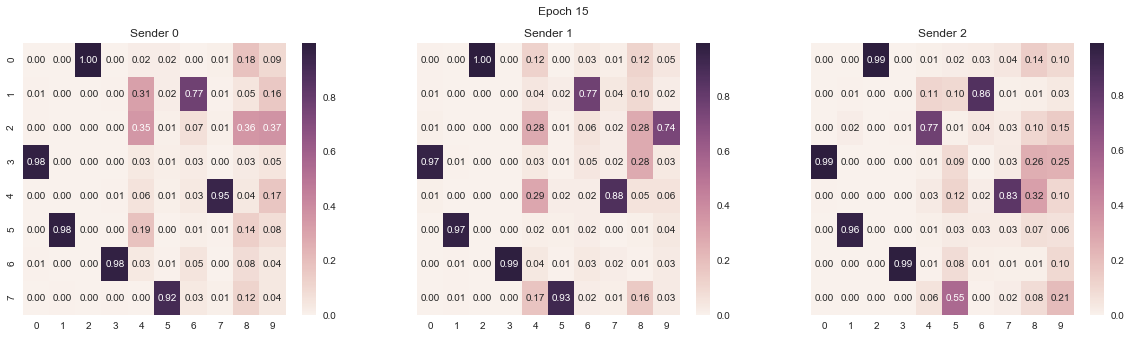

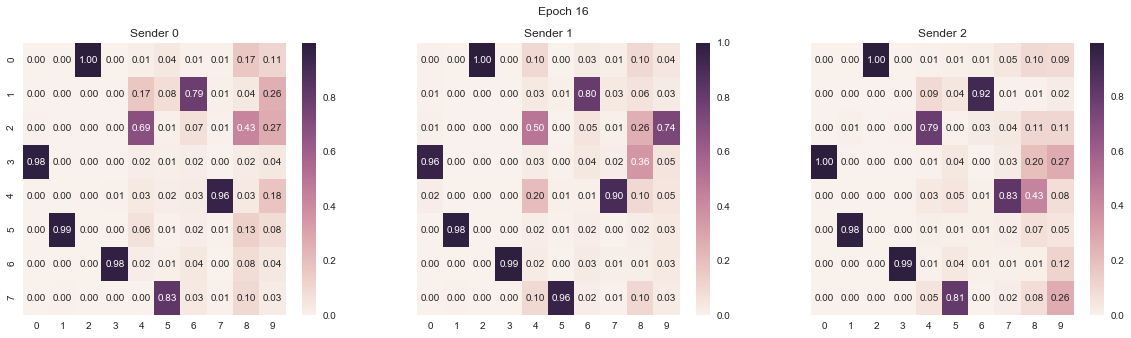

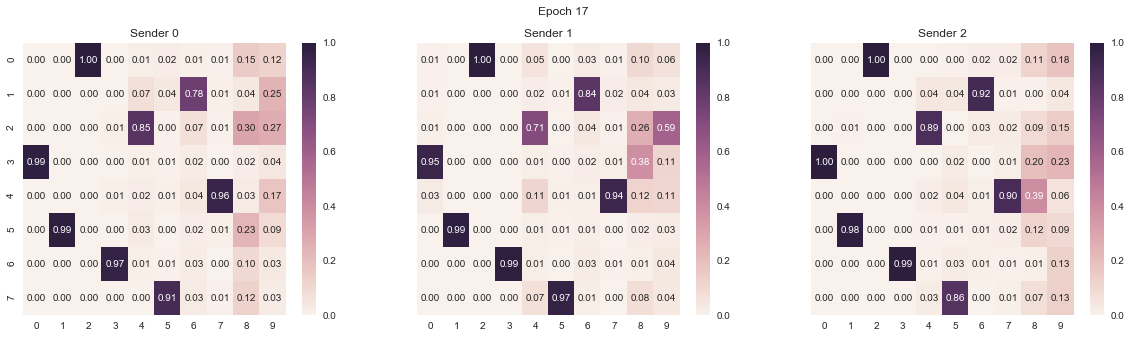

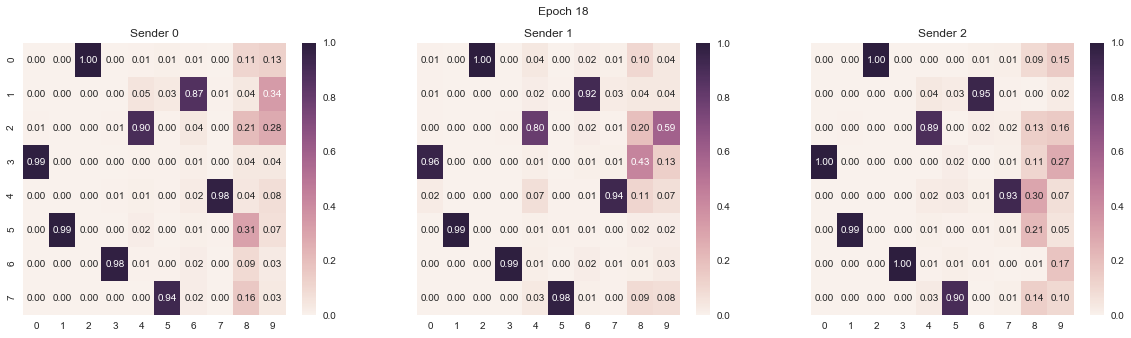

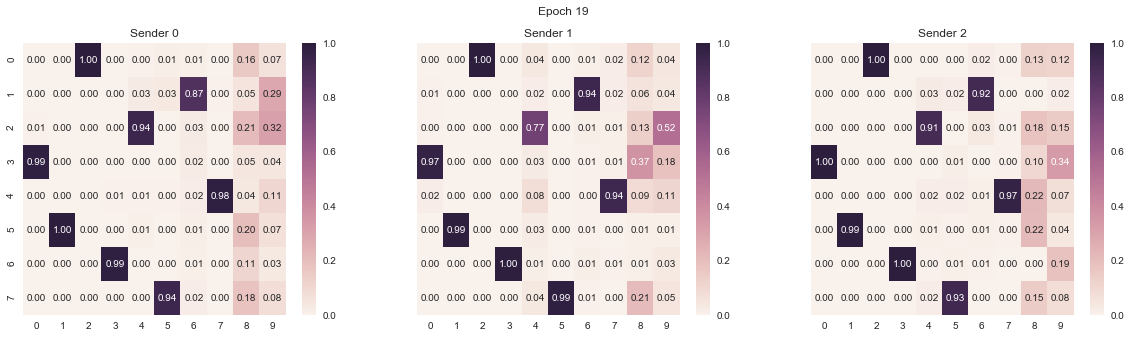

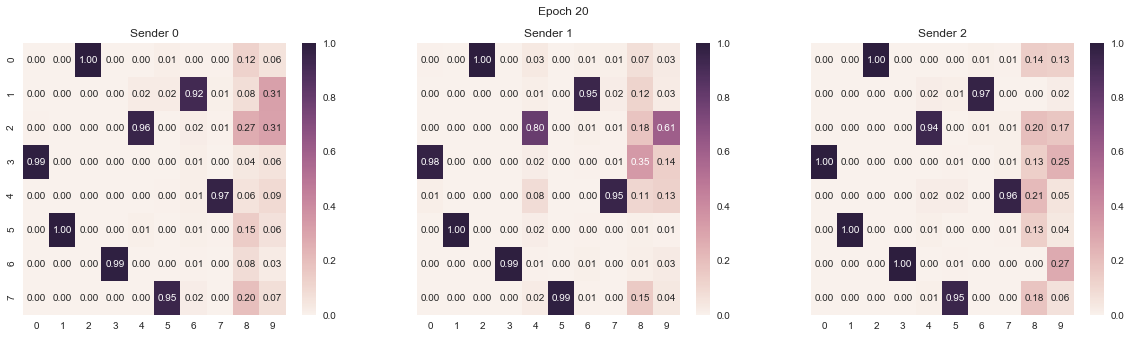

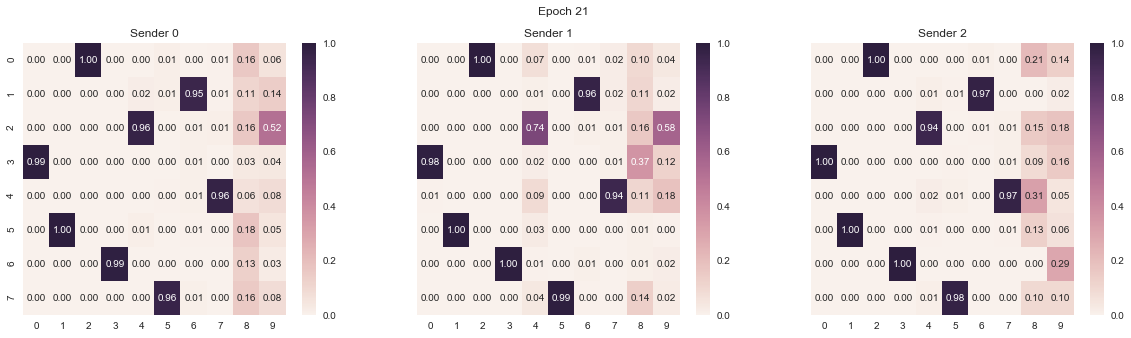

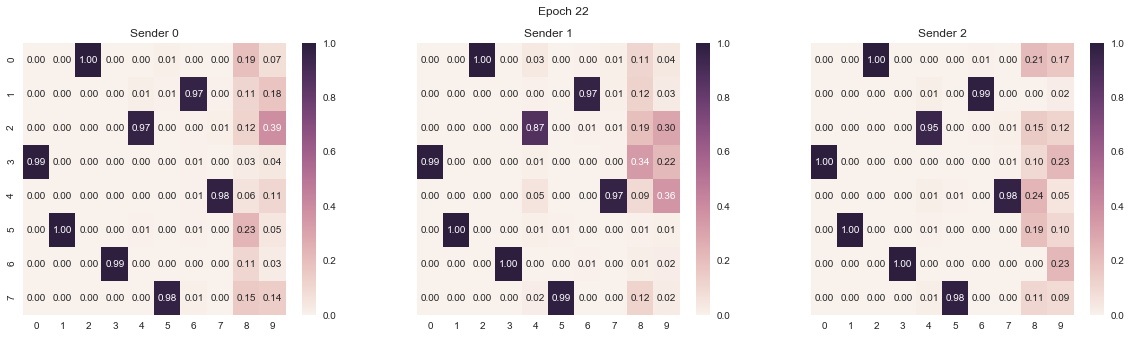

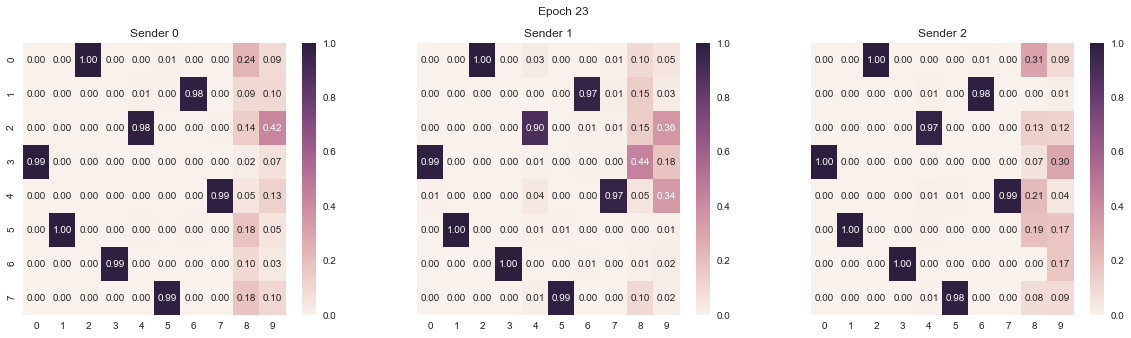

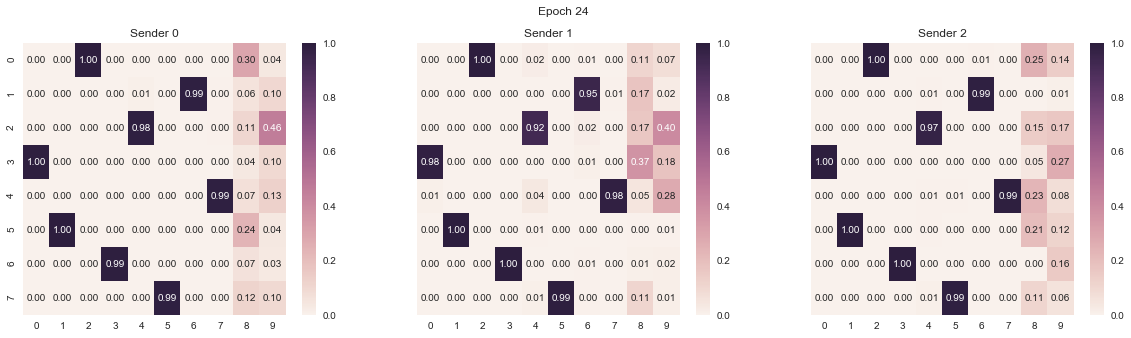

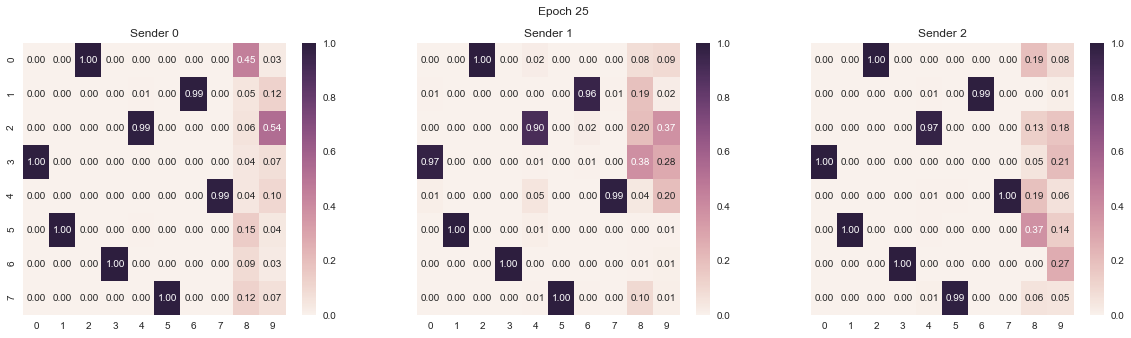

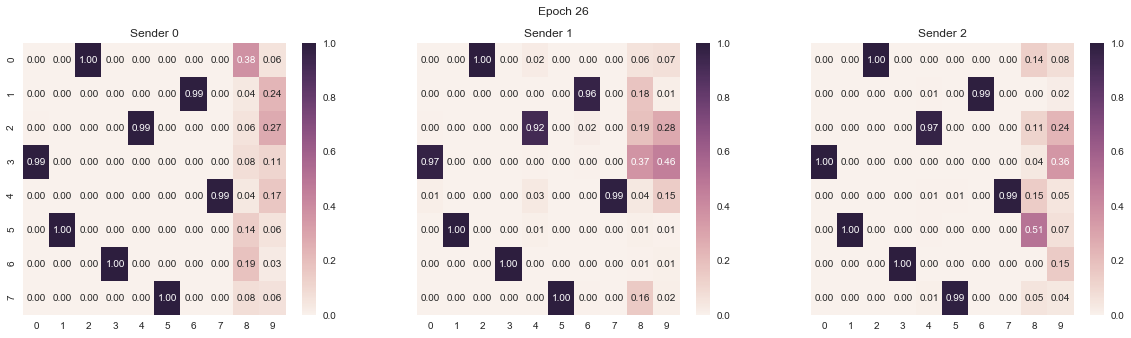

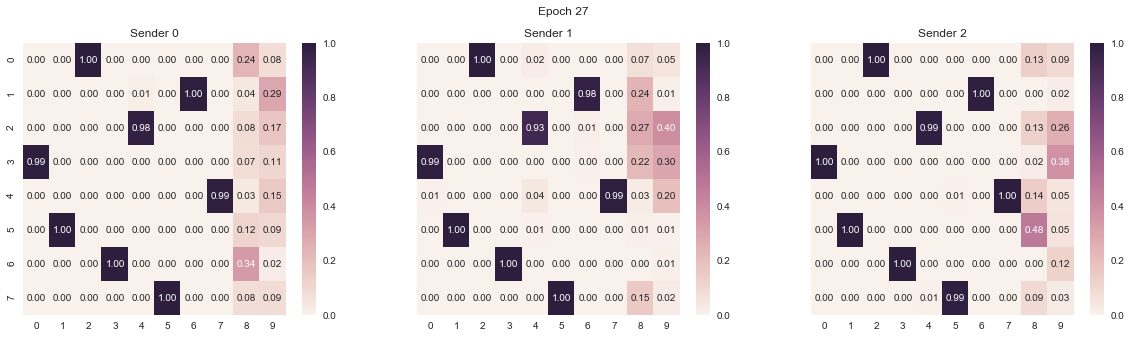

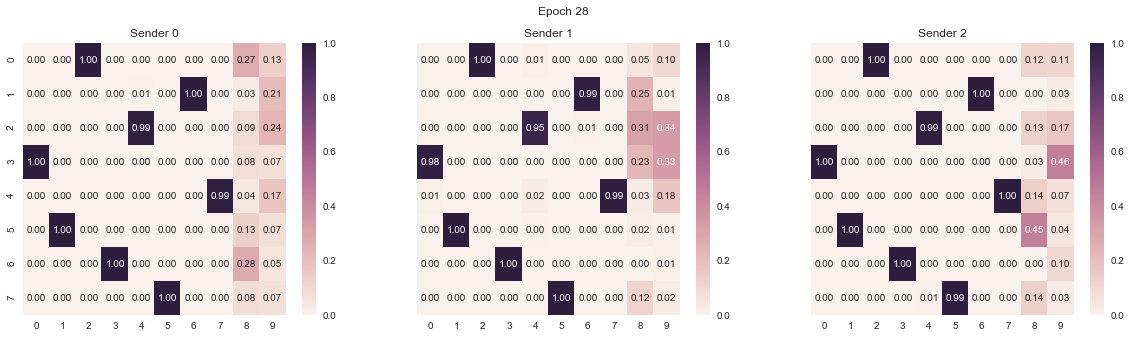

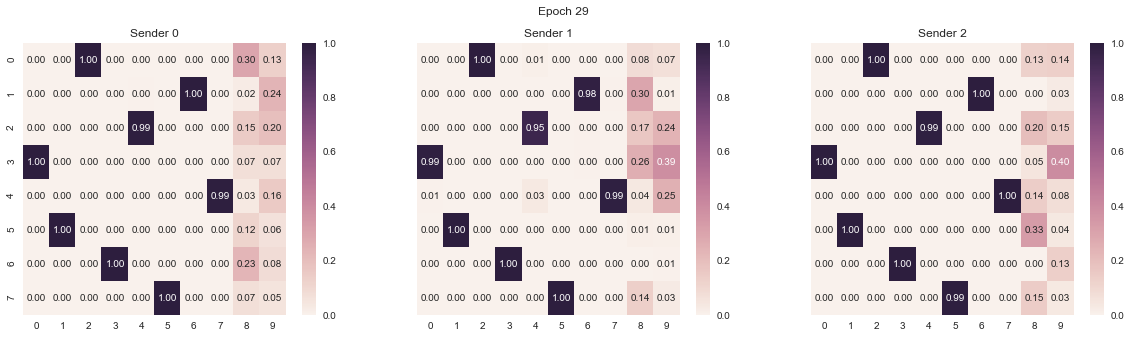

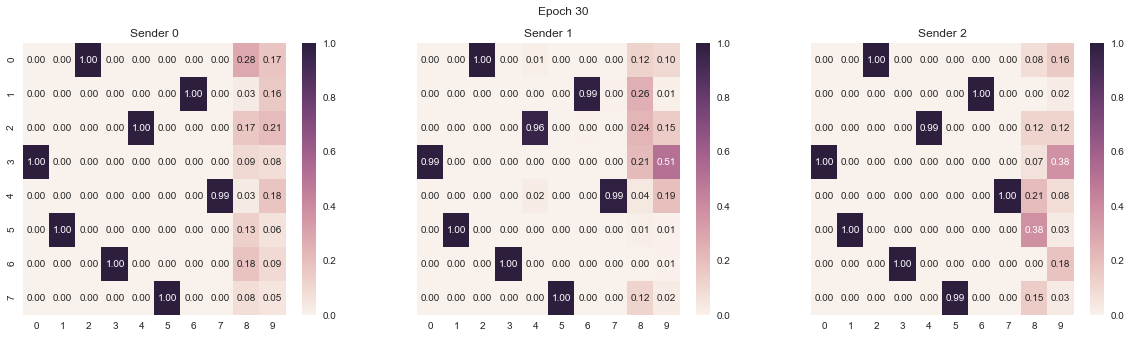

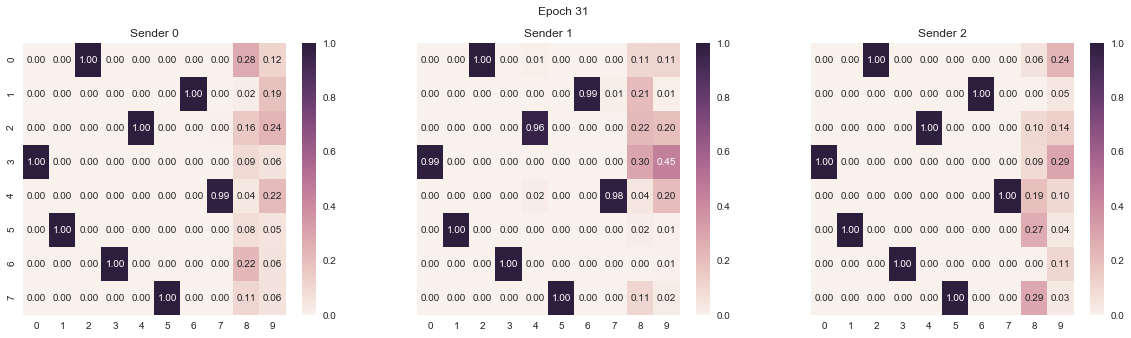

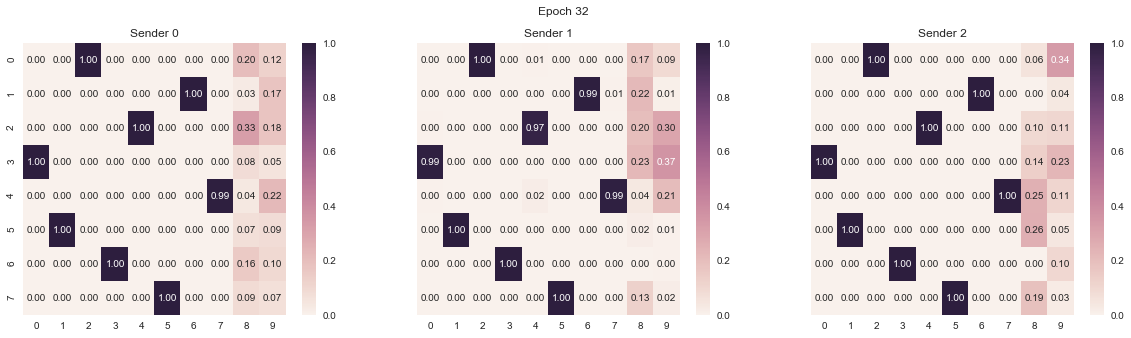

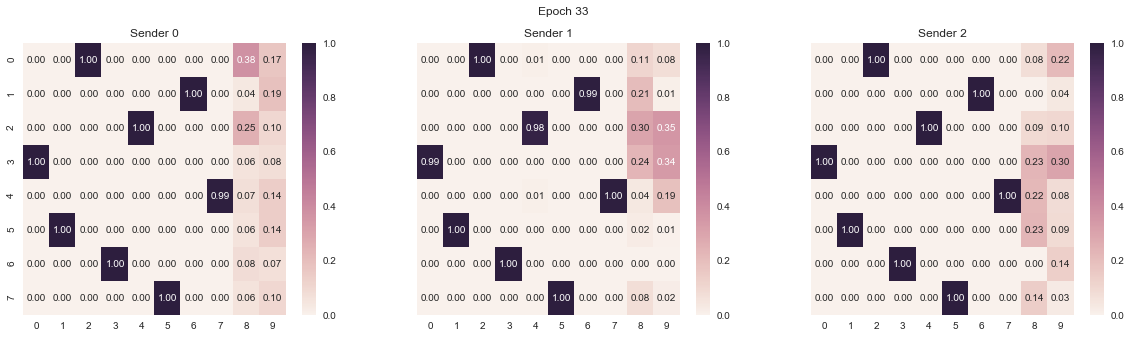

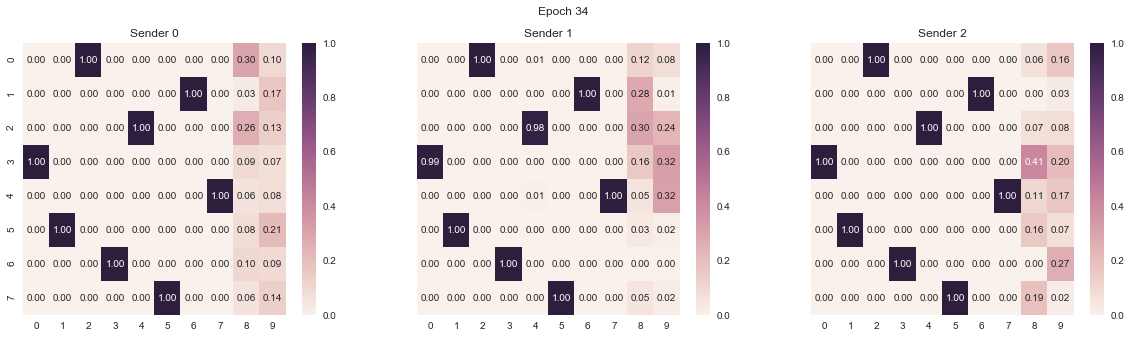

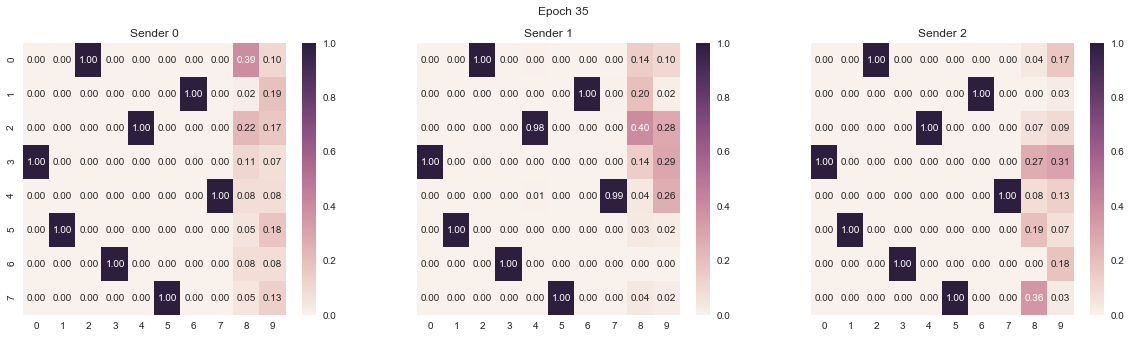

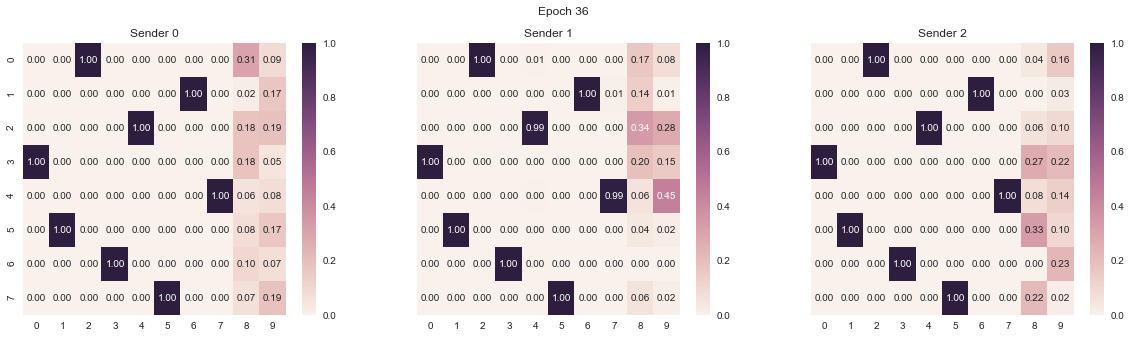

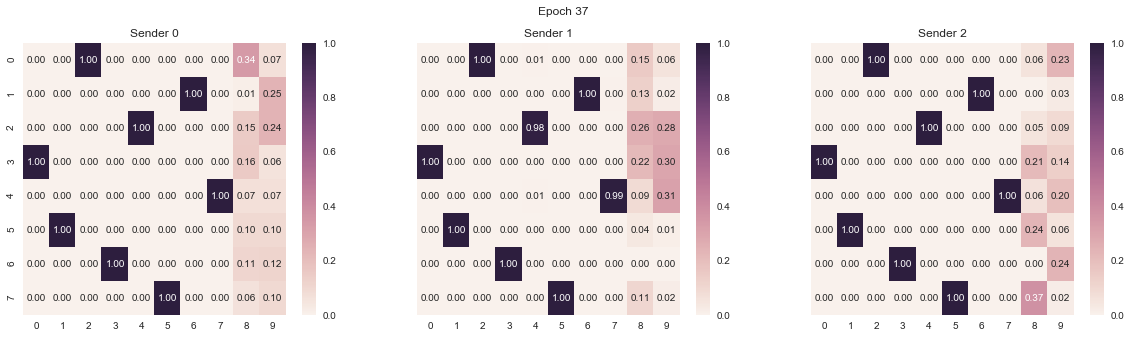

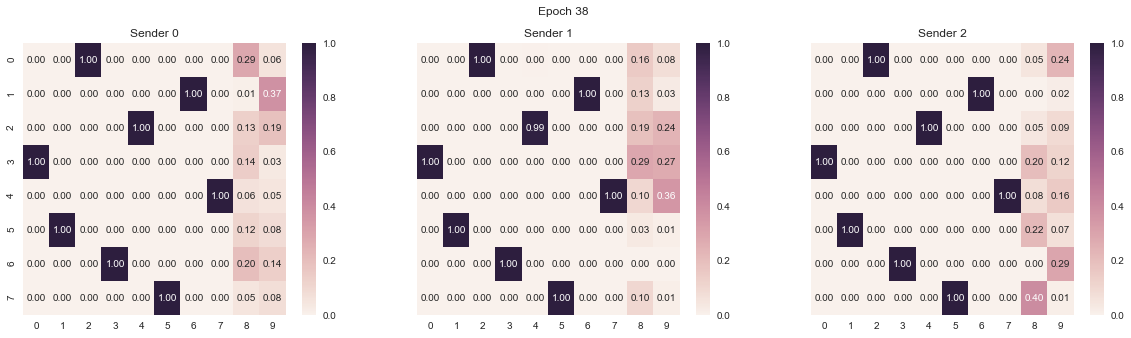

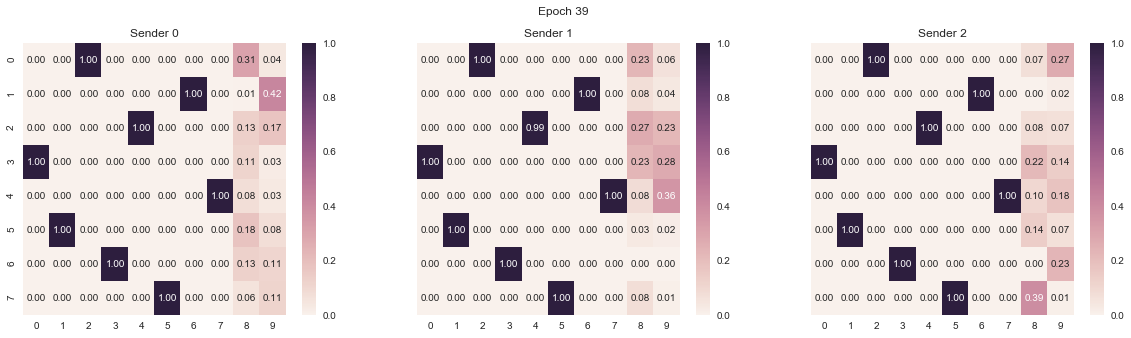

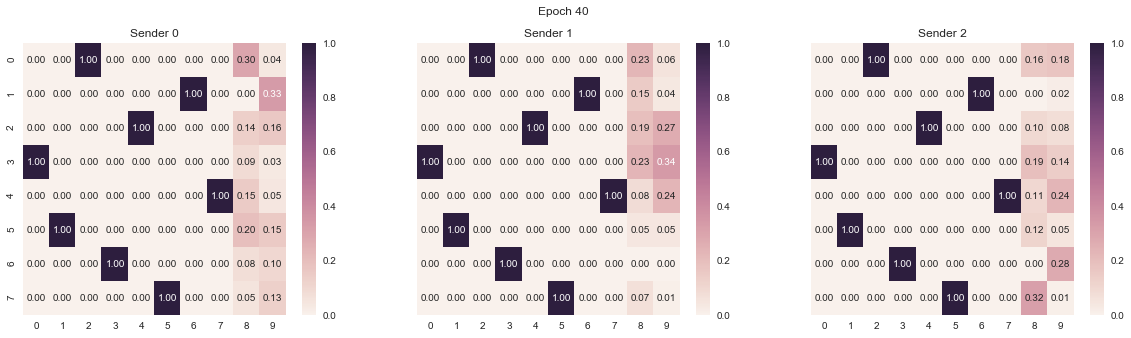

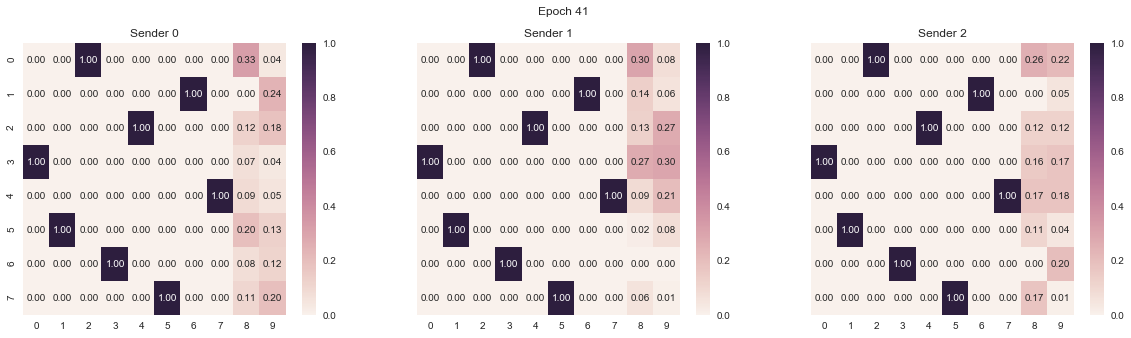

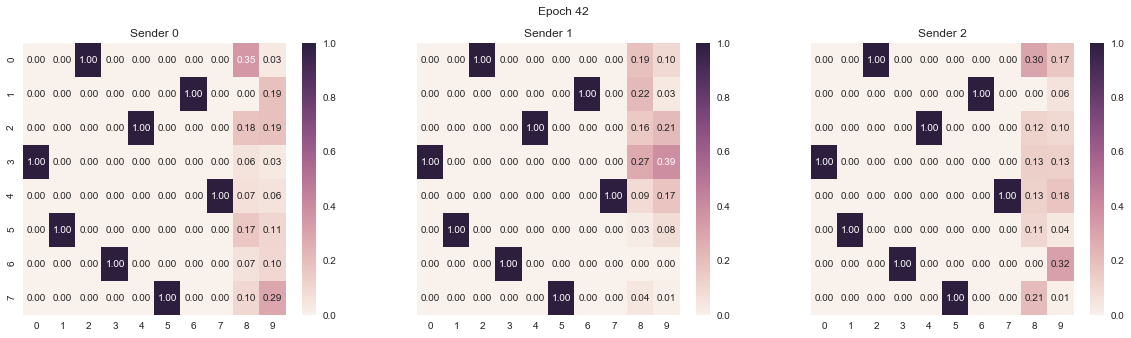

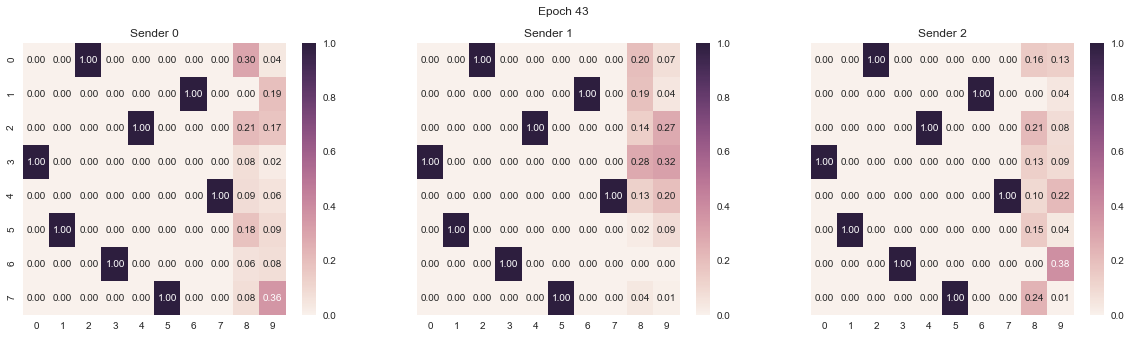

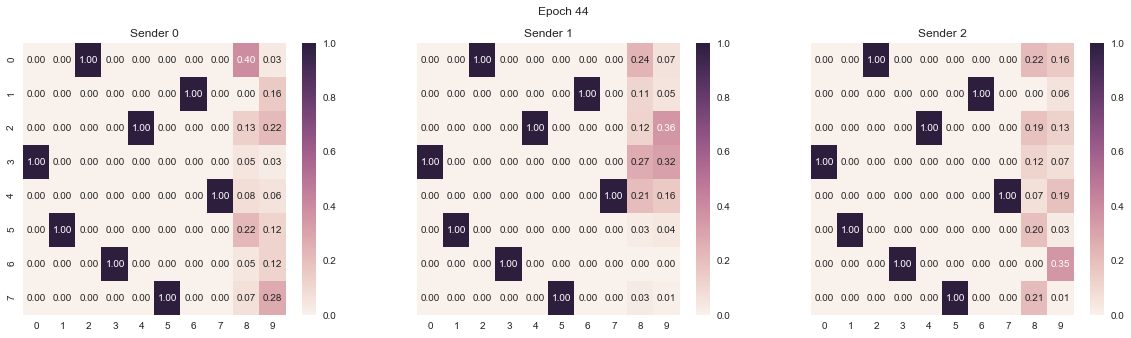

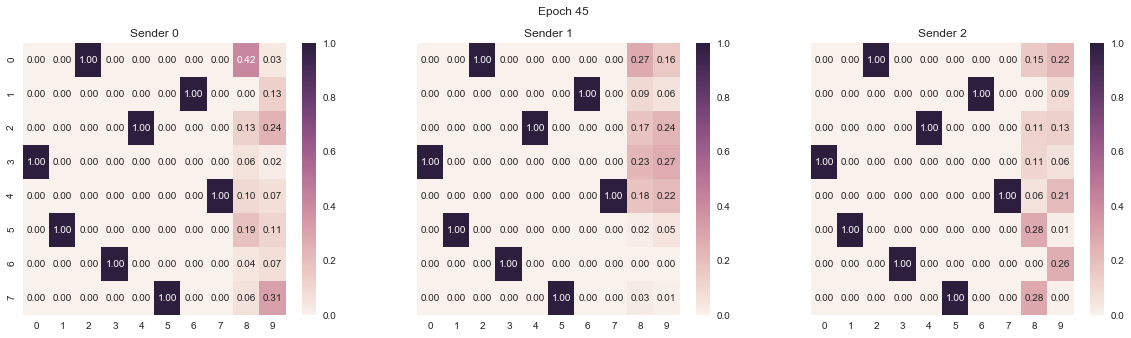

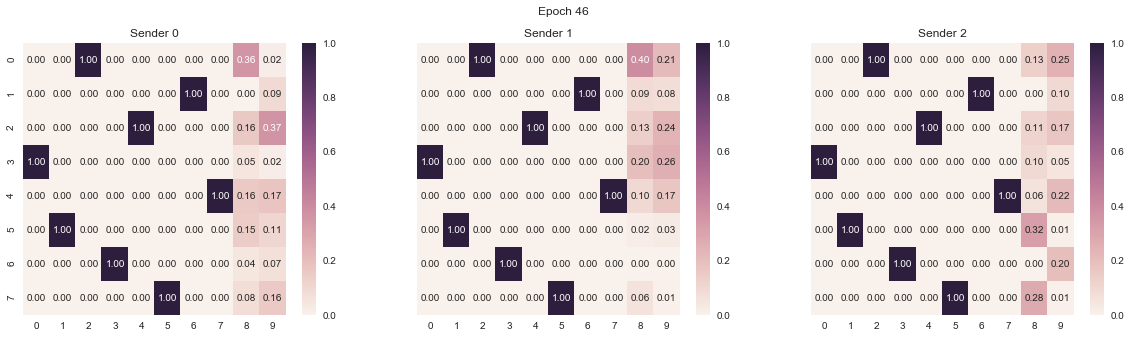

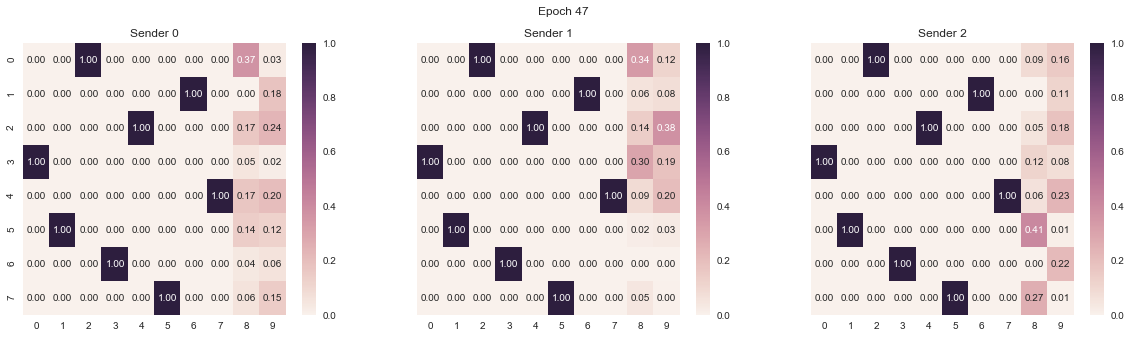

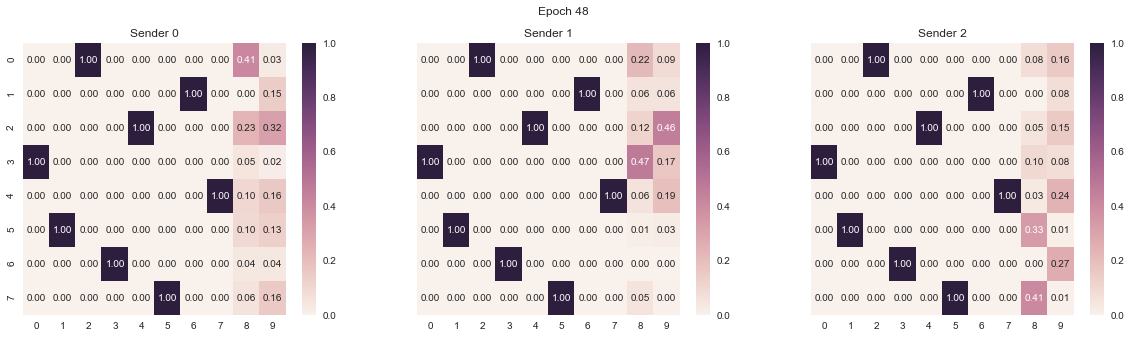

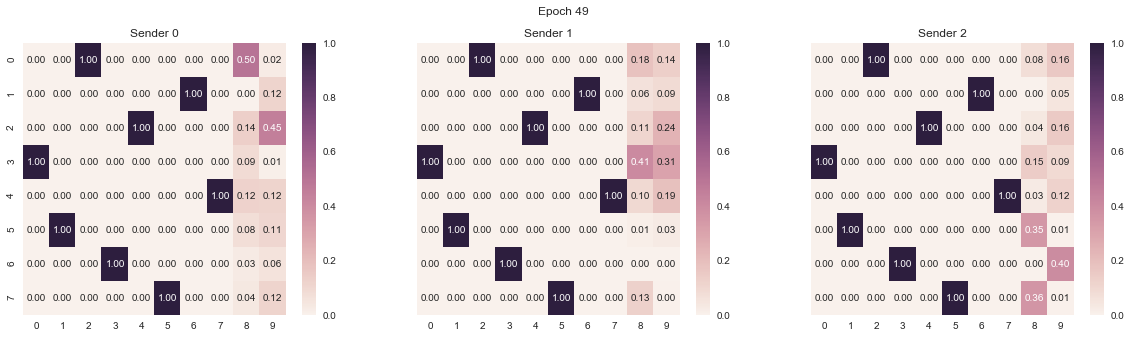

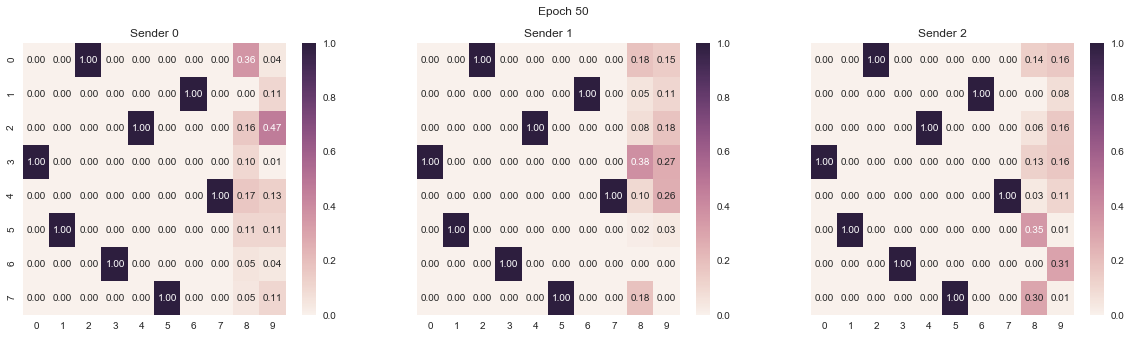

In [27]:
game = MultiAgentGame(senders, receivers, loss)
sender_params = [{'params': sender.parameters(), 'lr': opts.lr} for sender in senders]
receiver_params = [{'params': receiver.parameters(), 'lr': opts.lr} for receiver in receivers]
optimizer = torch.optim.Adam(sender_params+receiver_params)
neptune.init('tomekkorbak/EGG')
trainer = CustomTrainer(game=game, optimizer=optimizer, train_data=train_loader, validation_data=test_loader)
experiment = neptune.create_experiment(name='first-egg-experiment', tags=['egg', 'entropy'], params=vars(opts))
trainer.monitor = NeptuneMonitor(experiment=experiment)
trainer.train(n_epochs=opts.n_epochs)

In [28]:
experiment.stop()